# Genetic algorithms for solving Quadratic Assigment Problems

## Problem definition

In [7]:
import numpy as np

# Defining the problem
class QAProblem:

    def __init__(self, n, distances, flows):
        self.n = n
        self.distances = distances
        self.flows = flows

    def trad_eval(self, solution):
        cost = 0.
        for i in range(self.n):
            for j in range(self.n):
                dist = self.distances[i][j]
                flow = self.flows[solution[i]][solution[j]]
                cost += flow * dist
        return cost

    def symm_eval(self, solution):
        cost = 0
        for i in range(self.n-1):
            for j in range(i+1, self.n):
                dist = self.distances[i][j]
                flow = self.flows[solution[i]][solution[j]]
                cost += 2*(flow * dist)
        return cost

    def __call__(self, solution):
        perm_flow = self.flows[solution,:][:,solution]
        return int(np.multiply(self.distances, perm_flow).sum())

    def create_from_file(path):
        with open(path, "r") as f:
            n = int(f.readline().strip())
            distances, flows = np.zeros((n, n), dtype=int), np.zeros((n, n), dtype=int)
            _ = f.readline()
            for i in range(n):
                flows[i,:] = (list(map(int, f.readline().split())))
            for j in range(n):
                distances[j,:] = (list(map(int, f.readline().split())))
        return QAProblem(n, distances, flows)

# Reading data

qaProblem = QAProblem.create_from_file(path="tai256c.dat")

print(np.shape(qaProblem.distances))
print(np.shape(qaProblem.flows))


(256, 256)
(256, 256)


### Testing evaluation approaches

In [8]:
# Testing evaluation approaches
import time

np.random.seed(123)


# Number of solutions (individuals)
pop_size = 50

# Creating the solution set, (population)
pop = [np.random.permutation(qaProblem.n) for i in range(pop_size)]

# Collecting fitness evaluations
pop_fits = np.zeros((pop_size, 3), dtype=int)


# Traditional approache
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem.trad_eval(ind))
pop_fits[:, 0] = fits
end = time.time()
print(end - start)

# Exploiting symmetry
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem.symm_eval(ind))
pop_fits[:, 1] = fits
end = time.time()
print(end - start)

# Exploiting numpy multiplication and sum
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem(ind))
pop_fits[:, 2] = fits
end = time.time()
print(end - start)

# Checking fitness equallity between approaches

print((pop_fits[:,0] == pop_fits[:,1]).all())
print((pop_fits[:,0] == pop_fits[:,2]).all())
print((pop_fits[:,1] == pop_fits[:,2]).all())




2.318782091140747
1.1224579811096191
0.016816139221191406
True
True
True


## Algorithm definition

In [16]:
def cross_order(parent1, parent2):
    l = len(parent1)
    par_size = l // 2
    
    start_point = np.random.randint(l)
    cop_points = (start_point + np.array(range(par_size))) % l
    end_point = (start_point + par_size) % l
    # rep_points = (end_point + np.array(range(l - par_size))) % l
    rep_points_all = (end_point + np.array(range(l))) % l
    rep_points = rep_points_all[0:(l - par_size)]

    off1 = np.zeros(l, dtype=int)
    off2 = np.zeros(l, dtype=int)

    off1[cop_points] = parent1[cop_points]
    off2[cop_points] = parent2[cop_points]

    parent2_cont = np.setdiff1d(parent2[rep_points_all], off1[cop_points], assume_unique=True)
    parent1_cont = np.setdiff1d(parent1[rep_points_all], off2[cop_points], assume_unique=True)

    off1[rep_points] = parent2_cont[0:(l - par_size)]
    off2[rep_points] = parent1_cont[0:(l - par_size)]

    return off1, off2



    




    




class GAforQA:
    def __init__(self, qa_problem:QAProblem, pop_size:int=50, crossover_rate:float=0.7, mutation_rate:float=0.1) -> None:
        self.qa_problem = qa_problem
        self.pop_size = pop_size
        self.cross_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = np.empty((self.pop_size, self.qa_problem.n),  dtype=int)
        self.fitness = np.zeros(self.pop_size, dtype=int)

    def initialize(self):
        for i in range(self.pop_size):
            x = np.random.permutation(self.qa_problem.n)
            f = self.qa_problem(x)
            self.population[i,:] = x
            self.fitness[i] = f

    
    
    

ga_alg = GAforQA(qaProblem, pop_size=10)

ga_alg.initialize()





In [52]:
par1 = ga_alg.population[7]
par2 = ga_alg.population[9]

np.random.seed(134)
off1, off2 = cross_order(par1, par2)

print("Off1's Sim. with par1 {:.1f}%".format(np.sum(off1 == par1)/len(par1)*100))
print("Off1's Sim. with par2 {:.1f}%".format(np.sum(off1 == par2)/len(par2)*100))

print("Off2's Sim. with par1 {:.1f}%".format(np.sum(off2 == par1)/len(par1)*100))
print("Off2's Sim. with par2 {:.1f}%".format(np.sum(off2 == par2)/len(par2)*100))

print("par1's Sim. with par2 {:.1f}%".format(np.sum(par1 == par2)/len(par1)*100))


Off1's Sim. with par1 50.0%
Off1's Sim. with par2 0.0%
Off2's Sim. with par1 0.8%
Off2's Sim. with par2 50.4%
par1's Sim. with par2 0.8%


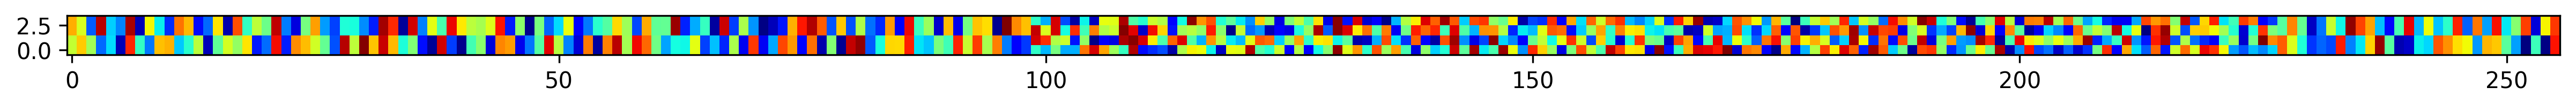

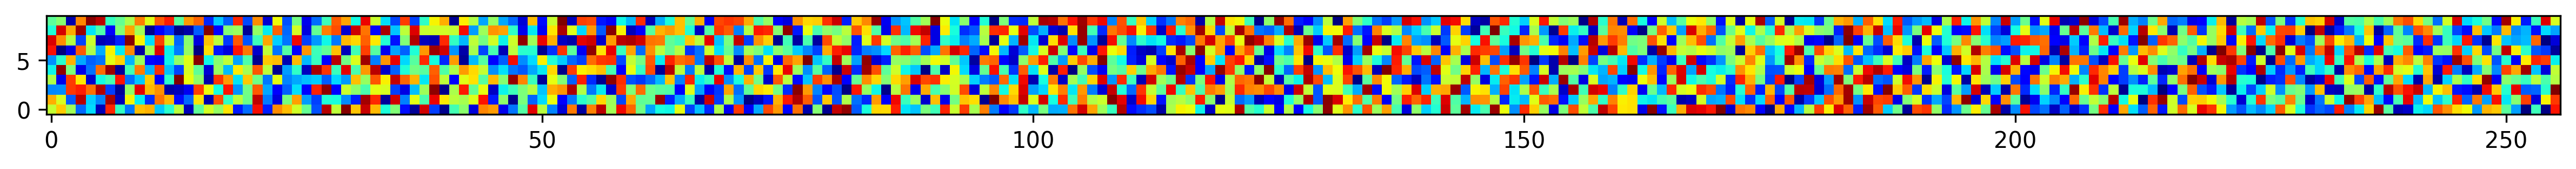

In [35]:
z = [
    par1,
    off1,
    par2,
    off2
]

import matplotlib as mpl
from matplotlib import pyplot as plt

plt.figure(figsize=(20,2))
plt.imshow(z,interpolation='none',cmap=plt.cm.jet,origin='lower') 
plt.show()

z = [
    par1,
    off2,
    par2,
    off1
]
plt.figure(figsize=(20,6))
plt.imshow(ga_alg.population,interpolation='none',cmap=plt.cm.jet,origin='lower') 
plt.show()